**Chapter 17 – Autoencoders**

_This notebook contains all the sample code in chapter 17._

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0-preview.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

A couple utility functions to plot grayscale 28x28 image:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

# PCA with a linear Autoencoder

Build 3D dataset:

In [3]:
np.random.seed(4)

m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)

Normalize the data:

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

Now let's build the Autoencoder...

In [5]:
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.1))
history = autoencoder.fit(X_train, X_train, epochs=20, validation_data=[X_test, X_test])

Train on 100 samples, validate on 100 samples
Epoch 1/20
100/100 [==============================] - 0s 3ms/sample - loss: 1.3767 - val_loss: 0.8100
Epoch 2/20
100/100 [==============================] - 0s 91us/sample - loss: 0.6408 - val_loss: 0.5684
Epoch 3/20
100/100 [==============================] - 0s 77us/sample - loss: 0.4541 - val_loss: 0.4266
Epoch 4/20
100/100 [==============================] - 0s 91us/sample - loss: 0.3436 - val_loss: 0.3135
Epoch 5/20
100/100 [==============================] - 0s 81us/sample - loss: 0.2516 - val_loss: 0.2268
Epoch 6/20
100/100 [==============================] - 0s 88us/sample - loss: 0.1858 - val_loss: 0.1720
Epoch 7/20
100/100 [==============================] - 0s 105us/sample - loss: 0.1440 - val_loss: 0.1308
Epoch 8/20
100/100 [==============================] - 0s 83us/sample - loss: 0.1140 - val_loss: 0.1072
Epoch 9/20
100/100 [==============================] - 0s 105us/sample - loss: 0.0955 - val_loss: 0.0903
Epoch 10/20
100/100 [=====

In [6]:
codings_test = encoder.predict(X_test)

Saving figure linear_autoencoder_pca_plot


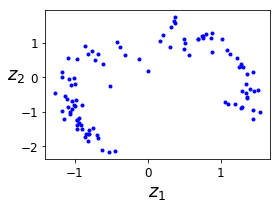

In [7]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_test[:,0], codings_test[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked Autoencoders

Let's use MNIST:

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255
X_test = X_test / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

## Train all layers at once

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [9]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.),
                   metrics=["accuracy"])
history = stacked_ae.fit(X_train, X_train, epochs=10,
                         validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 86us/sample - loss: 0.3474 - accuracy: 0.4987 - val_loss: 0.3166 - val_accuracy: 0.5005
Epoch 2/10
55000/55000 [==============================] - 4s 69us/sample - loss: 0.3089 - accuracy: 0.5054 - val_loss: 0.3061 - val_accuracy: 0.5030
Epoch 3/10
55000/55000 [==============================] - 4s 67us/sample - loss: 0.3020 - accuracy: 0.5064 - val_loss: 0.3016 - val_accuracy: 0.5031
Epoch 4/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.2976 - accuracy: 0.5070 - val_loss: 0.2972 - val_accuracy: 0.5041
Epoch 5/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.2946 - accuracy: 0.5074 - val_loss: 0.2948 - val_accuracy: 0.5042
Epoch 6/10
55000/55000 [==============================] - 4s 71us/sample - loss: 0.2926 - accuracy: 0.5076 - val_loss: 0.2937 - val_accuracy: 0.5042
Epoch 7/10
55000/55000 [==============================] -

This function processes a few test images through the autoencoder and displays the original images and their reconstructions:

In [10]:
def show_reconstructions(model, n_test_images = 2):
    reconstructions = model.predict(X_test[:n_test_images])
    fig = plt.figure(figsize=(8, 3 * n_test_images))
    for image_index in range(n_test_images):
        plt.subplot(n_test_images, 2, image_index * 2 + 1)
        plot_image(X_test[image_index])
        plt.subplot(n_test_images, 2, image_index * 2 + 2)
        plot_image(reconstructions[image_index])

Saving figure reconstruction_plot


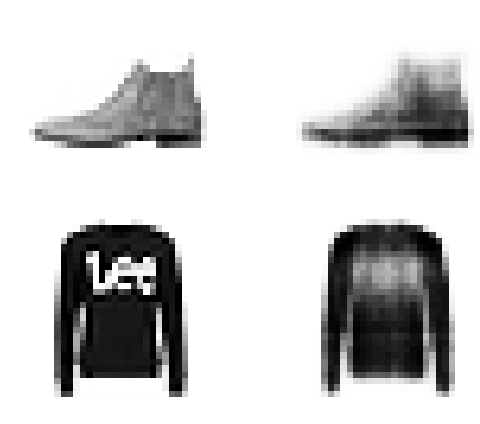

In [11]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

## Tying weights

It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.

In [12]:
K = keras.backend

class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias", shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        return self.activation(inputs @ K.transpose(self.dense.weights[0]) + self.biases)

In [13]:
tf.random.set_seed(42)
np.random.seed(42)

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
tied_decoder = keras.models.Sequential([
    DenseTranspose(tied_encoder.layers[2], activation="selu"),
    DenseTranspose(tied_encoder.layers[1], activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])
tied_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.),
                metrics=["accuracy"])
history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 80us/sample - loss: 0.3229 - accuracy: 0.5023 - val_loss: 0.3014 - val_accuracy: 0.5040
Epoch 2/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.2963 - accuracy: 0.5074 - val_loss: 0.3025 - val_accuracy: 0.5029
Epoch 3/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.2912 - accuracy: 0.5079 - val_loss: 0.2910 - val_accuracy: 0.5046
Epoch 4/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.2881 - accuracy: 0.5082 - val_loss: 0.2879 - val_accuracy: 0.5050
Epoch 5/10
55000/55000 [==============================] - 4s 71us/sample - loss: 0.2861 - accuracy: 0.5083 - val_loss: 0.2863 - val_accuracy: 0.5051
Epoch 6/10
55000/55000 [==============================] - 4s 69us/sample - loss: 0.2848 - accuracy: 0.5084 - val_loss: 0.2858 - val_accuracy: 0.5051
Epoch 7/10
55000/55000 [==============================] -

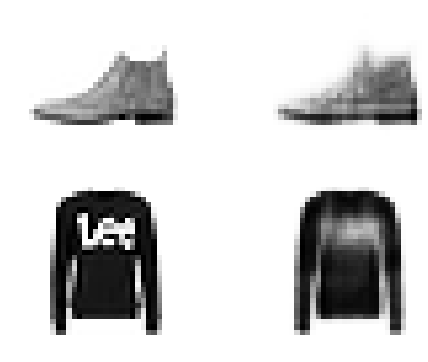

In [14]:
show_reconstructions(tied_ae)
plt.show()

## Training one Autoencoder at a time

In [15]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer, metrics=None,
                      n_epochs=10, output_activation=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=[X_valid, X_valid])
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [16]:
tf.random.set_seed(42)
np.random.seed(42)

X_train_flat = keras.layers.Flatten()(X_train)
X_valid_flat = keras.layers.Flatten()(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy", keras.optimizers.SGD(lr=0.1),
    output_activation="sigmoid", metrics=["accuracy"])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.Adam(),
    output_activation="selu")

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.5042 - accuracy: 0.4639 - val_loss: 0.4374 - val_accuracy: 0.4874
Epoch 2/10
55000/55000 [==============================] - 3s 63us/sample - loss: 0.4032 - accuracy: 0.4952 - val_loss: 0.3846 - val_accuracy: 0.4951
Epoch 3/10
55000/55000 [==============================] - 3s 61us/sample - loss: 0.3696 - accuracy: 0.4996 - val_loss: 0.3624 - val_accuracy: 0.4975
Epoch 4/10
55000/55000 [==============================] - 4s 65us/sample - loss: 0.3520 - accuracy: 0.5016 - val_loss: 0.3482 - val_accuracy: 0.4992
Epoch 5/10
55000/55000 [==============================] - 4s 67us/sample - loss: 0.3406 - accuracy: 0.5029 - val_loss: 0.3389 - val_accuracy: 0.5002
Epoch 6/10
55000/55000 [==============================] - 3s 64us/sample - loss: 0.3330 - accuracy: 0.5037 - val_loss: 0.3325 - val_accuracy: 0.5008
Epoch 7/10
55000/55000 [==============================] -

In [17]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1,
    enc2,
    dec2,
    dec1,
    keras.layers.Reshape([28, 28])
])

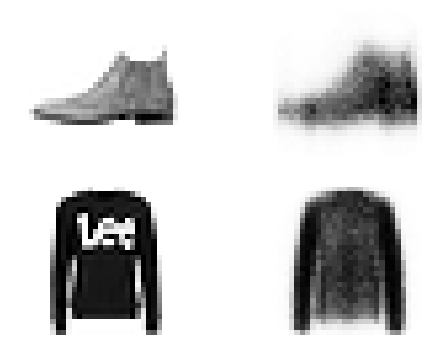

In [18]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [19]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=0.5),
                          metrics=["accuracy"])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3109 - accuracy: 0.5057 - val_loss: 0.3080 - val_accuracy: 0.5032
Epoch 2/10
55000/55000 [==============================] - 4s 65us/sample - loss: 0.3034 - accuracy: 0.5066 - val_loss: 0.3029 - val_accuracy: 0.5039
Epoch 3/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2989 - accuracy: 0.5072 - val_loss: 0.2991 - val_accuracy: 0.5042
Epoch 4/10
55000/55000 [==============================] - 4s 69us/sample - loss: 0.2954 - accuracy: 0.5076 - val_loss: 0.2958 - val_accuracy: 0.5047
Epoch 5/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.2926 - accuracy: 0.5079 - val_loss: 0.2935 - val_accuracy: 0.5048
Epoch 6/10
55000/55000 [==============================] - 4s 80us/sample - loss: 0.2906 - accuracy: 0.5080 - val_loss: 0.2915 - val_accuracy: 0.5051
Epoch 7/10
55000/55000 [==============================] -

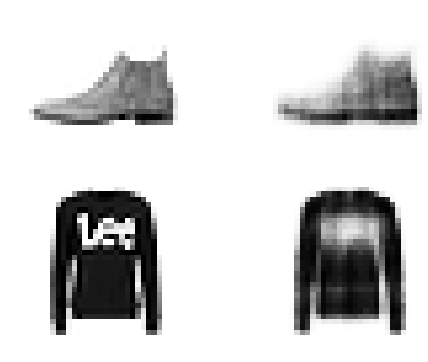

In [20]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## Visualizing the extracted features

Saving figure extracted_features_plot


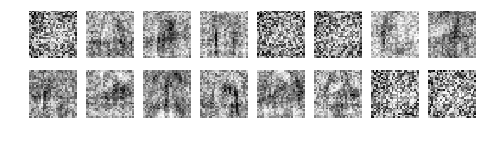

In [21]:
weights1 = stacked_ae_1_by_1.layers[1].get_weights()[0]
plt.figure(figsize=(8, 2))
n_rows, n_cols = 2, 8
for row in range(n_rows):
    for col in range(n_cols):
        index = row * n_cols + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(weights1[:, index].reshape(28, 28), cmap="Greys")
        plt.axis("off")

save_fig("extracted_features_plot", tight_layout=False) # not shown
plt.show()                          # not shown

## Using Convolutional Layers Instead of Dense Layers

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [22]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=["accuracy"])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 40s 734us/sample - loss: 0.3017 - accuracy: 0.5064 - val_loss: 0.2842 - val_accuracy: 0.5058
Epoch 2/5
55000/55000 [==============================] - 39s 712us/sample - loss: 0.2756 - accuracy: 0.5088 - val_loss: 0.2739 - val_accuracy: 0.5058
Epoch 3/5
55000/55000 [==============================] - 39s 715us/sample - loss: 0.2709 - accuracy: 0.5092 - val_loss: 0.2720 - val_accuracy: 0.5059
Epoch 4/5
55000/55000 [==============================] - 39s 707us/sample - loss: 0.2682 - accuracy: 0.5094 - val_loss: 0.2685 - val_accuracy: 0.5063
Epoch 5/5
55000/55000 [==============================] - 39s 706us/sample - loss: 0.2665 - accuracy: 0.5095 - val_loss: 0.2671 - val_accuracy: 0.5066


In [23]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)        

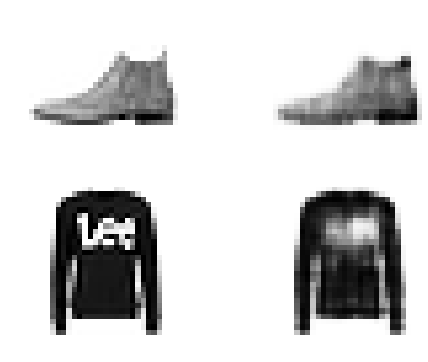

In [24]:
show_reconstructions(conv_ae)
plt.show()

## Unsupervised pretraining

Let's create a small neural network for MNIST classification:

In [25]:
tf.random.set_seed(42)
np.random.seed(42)

X_train_small = X_train[:500]
y_train_small = y_train[:500]

classifier = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation="selu"),
    keras.layers.Dense(10, activation="softmax")
])
classifier.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=0.02), metrics=["accuracy"])
history = classifier.fit(X_train_small, y_train_small, epochs=20, validation_data=[X_valid, y_valid])

Train on 500 samples, validate on 5000 samples
Epoch 1/20
500/500 [==============================] - 1s 3ms/sample - loss: 2.1965 - accuracy: 0.2480 - val_loss: 2.0234 - val_accuracy: 0.3148
Epoch 2/20
500/500 [==============================] - 1s 2ms/sample - loss: 1.7927 - accuracy: 0.5180 - val_loss: 1.5677 - val_accuracy: 0.6280
Epoch 3/20
500/500 [==============================] - 1s 2ms/sample - loss: 1.3931 - accuracy: 0.6360 - val_loss: 1.2556 - val_accuracy: 0.5482
Epoch 4/20
500/500 [==============================] - 1s 2ms/sample - loss: 1.1168 - accuracy: 0.6620 - val_loss: 0.9990 - val_accuracy: 0.6892
Epoch 5/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.9421 - accuracy: 0.7360 - val_loss: 1.1235 - val_accuracy: 0.6208
Epoch 6/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.8392 - accuracy: 0.7240 - val_loss: 0.8985 - val_accuracy: 0.6778
Epoch 7/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.7738 - accu

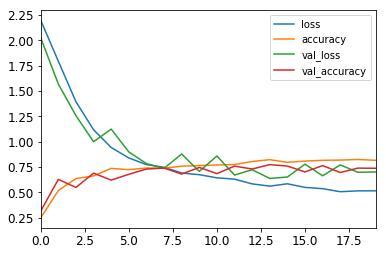

In [26]:
import pandas as pd
pd.DataFrame(history.history).plot()
plt.show()

In [27]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder_clone = keras.models.clone_model(conv_encoder)

pretrained_clf = keras.models.Sequential([
    conv_encoder_clone,
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation="selu"),
    keras.layers.Dense(10, activation="softmax")
])

In [28]:
conv_encoder_clone.trainable = False
pretrained_clf.compile(loss="sparse_categorical_crossentropy",
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=["accuracy"])
history = pretrained_clf.fit(X_train_small, y_train_small, epochs=30,
                             validation_data=[X_valid, y_valid])

Train on 500 samples, validate on 5000 samples
Epoch 1/30
500/500 [==============================] - 1s 3ms/sample - loss: 2.3174 - accuracy: 0.1820 - val_loss: 2.2350 - val_accuracy: 0.2156
Epoch 2/30
500/500 [==============================] - 1s 2ms/sample - loss: 2.1829 - accuracy: 0.2760 - val_loss: 2.1267 - val_accuracy: 0.3650
Epoch 3/30
500/500 [==============================] - 1s 2ms/sample - loss: 2.0852 - accuracy: 0.3880 - val_loss: 2.0370 - val_accuracy: 0.4378
Epoch 4/30
500/500 [==============================] - 1s 2ms/sample - loss: 1.9953 - accuracy: 0.4500 - val_loss: 1.9513 - val_accuracy: 0.5028
Epoch 5/30
500/500 [==============================] - 1s 2ms/sample - loss: 1.9117 - accuracy: 0.5860 - val_loss: 1.8742 - val_accuracy: 0.5610
Epoch 6/30
500/500 [==============================] - 1s 1ms/sample - loss: 1.8310 - accuracy: 0.6180 - val_loss: 1.7963 - val_accuracy: 0.6242
Epoch 7/30
500/500 [==============================] - 1s 1ms/sample - loss: 1.7526 - accu

In [29]:
conv_encoder_clone.trainable = True
pretrained_clf.compile(loss="sparse_categorical_crossentropy",
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=["accuracy"])
history = pretrained_clf.fit(X_train_small, y_train_small, epochs=20,
                             validation_data=[X_valid, y_valid])

Train on 500 samples, validate on 5000 samples
Epoch 1/20
500/500 [==============================] - 1s 3ms/sample - loss: 0.8479 - accuracy: 0.7360 - val_loss: 0.8023 - val_accuracy: 0.7154
Epoch 2/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.7508 - accuracy: 0.7480 - val_loss: 0.7908 - val_accuracy: 0.7062
Epoch 3/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.6956 - accuracy: 0.7700 - val_loss: 0.8156 - val_accuracy: 0.7006
Epoch 4/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.6806 - accuracy: 0.7700 - val_loss: 0.7408 - val_accuracy: 0.7244
Epoch 5/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.6563 - accuracy: 0.7700 - val_loss: 0.6731 - val_accuracy: 0.7540
Epoch 6/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.6262 - accuracy: 0.7920 - val_loss: 0.7332 - val_accuracy: 0.7316
Epoch 7/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.6039 - accu

# Stacked denoising Autoencoder

Using Gaussian noise:

In [30]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(1.0),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=["accuracy"])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 82us/sample - loss: 0.3772 - accuracy: 0.4927 - val_loss: 0.3322 - val_accuracy: 0.4955
Epoch 2/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.3364 - accuracy: 0.5007 - val_loss: 0.3207 - val_accuracy: 0.4994
Epoch 3/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3314 - accuracy: 0.5013 - val_loss: 0.3197 - val_accuracy: 0.4984
Epoch 4/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.3290 - accuracy: 0.5017 - val_loss: 0.3153 - val_accuracy: 0.5003
Epoch 5/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3271 - accuracy: 0.5020 - val_loss: 0.3146 - val_accuracy: 0.5018
Epoch 6/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3258 - accuracy: 0.5022 - val_loss: 0.3124 - val_accuracy: 0.5011
Epoch 7/10
55000/55000 [==============================] -

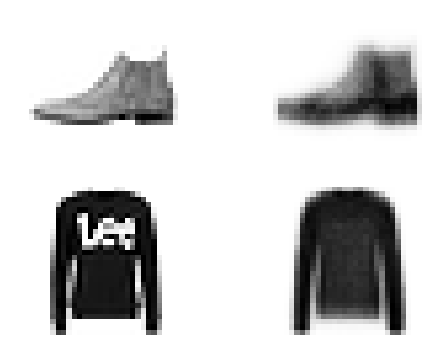

In [31]:
show_reconstructions(denoising_ae)
plt.show()

Using dropout:

In [32]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=["accuracy"])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.3564 - accuracy: 0.4969 - val_loss: 0.3206 - val_accuracy: 0.5011
Epoch 2/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.3182 - accuracy: 0.5034 - val_loss: 0.3113 - val_accuracy: 0.5014
Epoch 3/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3130 - accuracy: 0.5042 - val_loss: 0.3079 - val_accuracy: 0.5012
Epoch 4/10
55000/55000 [==============================] - 4s 71us/sample - loss: 0.3091 - accuracy: 0.5048 - val_loss: 0.3037 - val_accuracy: 0.5026
Epoch 5/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3066 - accuracy: 0.5052 - val_loss: 0.3032 - val_accuracy: 0.5016
Epoch 6/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3047 - accuracy: 0.5054 - val_loss: 0.3001 - val_accuracy: 0.5032
Epoch 7/10
55000/55000 [==============================] -

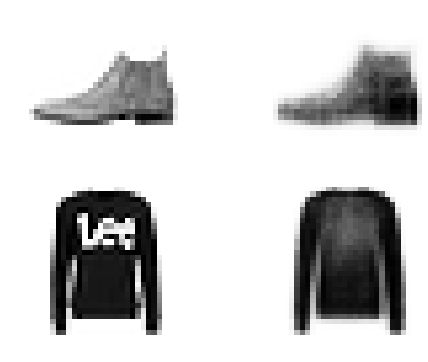

In [33]:
show_reconstructions(dropout_ae)
plt.show()

# Sparse Autoencoder

Let's build a simple stacked autoencoder, but this time we will use the sigmoid activation function for the coding layer, to ensure that the coding values range from 0 to 1:

In [34]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.),
                  metrics=["accuracy"])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 78us/sample - loss: 0.4331 - accuracy: 0.4906 - val_loss: 0.3778 - val_accuracy: 0.4911
Epoch 2/10
55000/55000 [==============================] - 4s 67us/sample - loss: 0.3610 - accuracy: 0.4976 - val_loss: 0.3510 - val_accuracy: 0.4972
Epoch 3/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.3405 - accuracy: 0.5006 - val_loss: 0.3359 - val_accuracy: 0.4990
Epoch 4/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.3276 - accuracy: 0.5027 - val_loss: 0.3248 - val_accuracy: 0.5003
Epoch 5/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.3206 - accuracy: 0.5035 - val_loss: 0.3206 - val_accuracy: 0.5007
Epoch 6/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.3172 - accuracy: 0.5038 - val_loss: 0.3176 - val_accuracy: 0.5010
Epoch 7/10
55000/55000 [==============================] -

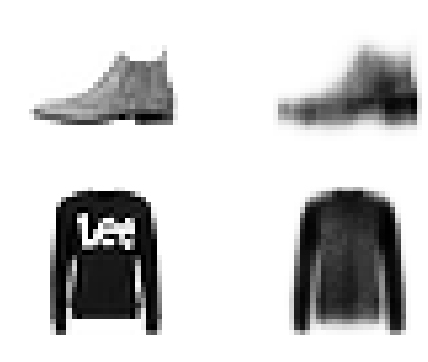

In [35]:
show_reconstructions(simple_ae)
plt.show()

Let's create a couple functions to print nice activation histograms:

In [36]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [37]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

Let's use these functions to plot histograms of the activations of the encoding layer. The histogram on the left shows the distribution of all the activations. You can see that values close to 0 or 1 are more frequent overall, which is consistent with the saturating nature of the sigmoid function. The histogram on the right shows the distribution of mean neuron activations: you can see that most neurons have a mean activation close to 0.5. Both histograms tell us that each neuron tends to either fire close to 0 or 1, with about 50% probability each. However, some neurons fire almost all the time (right side of the right histogram).

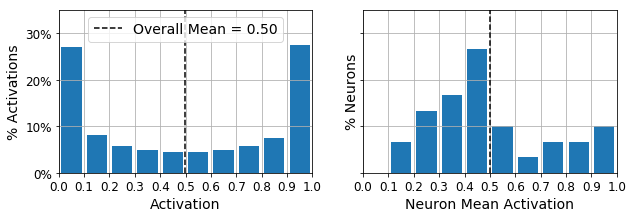

In [38]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

Now let's add $\ell_1$ regularization to the coding layer:

In [39]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=["accuracy"])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 98us/sample - loss: 0.4306 - accuracy: 0.4947 - val_loss: 0.3819 - val_accuracy: 0.4897
Epoch 2/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3689 - accuracy: 0.4971 - val_loss: 0.3639 - val_accuracy: 0.4940
Epoch 3/10
55000/55000 [==============================] - 5s 86us/sample - loss: 0.3553 - accuracy: 0.4987 - val_loss: 0.3513 - val_accuracy: 0.4970
Epoch 4/10
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3443 - accuracy: 0.5003 - val_loss: 0.3428 - val_accuracy: 0.4964
Epoch 5/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.3379 - accuracy: 0.5009 - val_loss: 0.3372 - val_accuracy: 0.4979
Epoch 6/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.3332 - accuracy: 0.5015 - val_loss: 0.3329 - val_accuracy: 0.4980
Epoch 7/10
55000/55000 [==============================] -

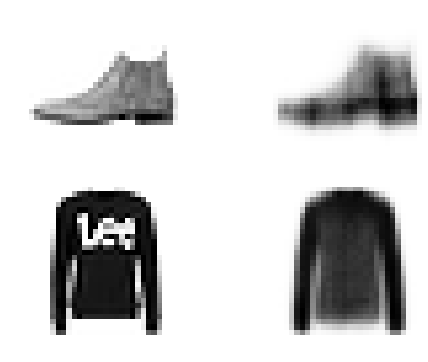

In [40]:
show_reconstructions(sparse_l1_ae)

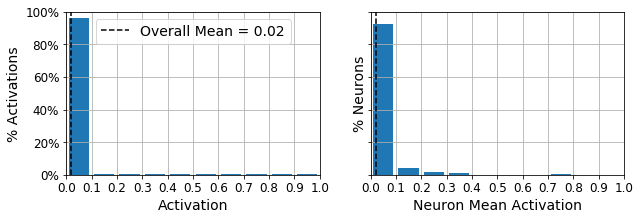

In [41]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

Let's use the KL Divergence loss instead to ensure sparsity, and target 10% sparsity rather than 0%:

Saving figure sparsity_loss_plot


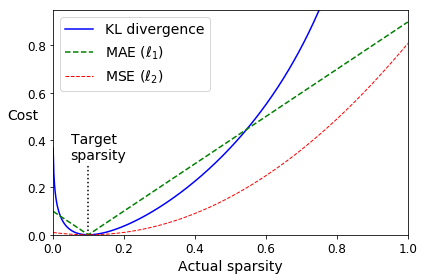

In [42]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [43]:
K = keras.backend

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            keras.losses.kullback_leibler_divergence(self.target, mean_activities) +
            keras.losses.kullback_leibler_divergence(1. - self.target, 1. - mean_activities))

In [44]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
              metrics=["accuracy"])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 85us/sample - loss: 0.4151 - accuracy: 0.4948 - val_loss: 0.3714 - val_accuracy: 0.4929
Epoch 2/10
55000/55000 [==============================] - 4s 74us/sample - loss: 0.3532 - accuracy: 0.4987 - val_loss: 0.3442 - val_accuracy: 0.4968
Epoch 3/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3340 - accuracy: 0.5013 - val_loss: 0.3292 - val_accuracy: 0.4994
Epoch 4/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3224 - accuracy: 0.5035 - val_loss: 0.3213 - val_accuracy: 0.5009
Epoch 5/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.3170 - accuracy: 0.5043 - val_loss: 0.3170 - val_accuracy: 0.5015
Epoch 6/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.3134 - accuracy: 0.5048 - val_loss: 0.3140 - val_accuracy: 0.5018
Epoch 7/10
55000/55000 [==============================] -

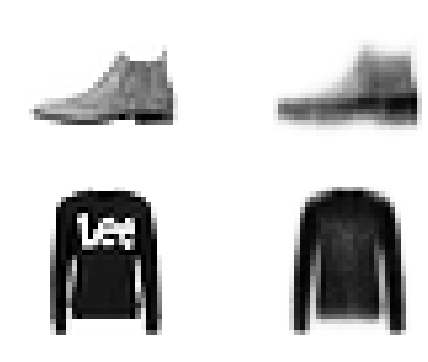

In [45]:
show_reconstructions(sparse_kl_ae)

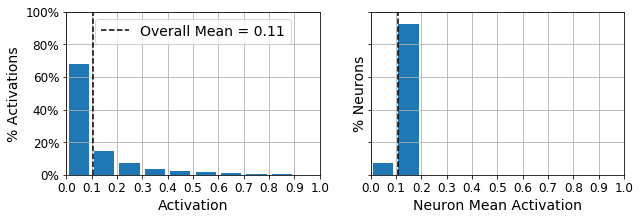

In [46]:
plot_activations_histogram(sparse_kl_encoder)
plt.show()

## Hashing Autoencoder

In [47]:
tf.random.set_seed(42)
np.random.seed(42)

hashing_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.GaussianNoise(15.),
    keras.layers.Dense(16, activation="sigmoid"),
])
hashing_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[16]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
hashing_ae = keras.models.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=["accuracy"])
history = hashing_ae.fit(X_train, X_train, epochs=10,
                         validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.4999 - accuracy: 0.4830 - val_loss: 0.4866 - val_accuracy: 0.4815
Epoch 2/10
55000/55000 [==============================] - 4s 69us/sample - loss: 0.4780 - accuracy: 0.4892 - val_loss: 0.4768 - val_accuracy: 0.4540
Epoch 3/10
55000/55000 [==============================] - 4s 69us/sample - loss: 0.4284 - accuracy: 0.4889 - val_loss: 0.4229 - val_accuracy: 0.4757
Epoch 4/10
55000/55000 [==============================] - 4s 70us/sample - loss: 0.4088 - accuracy: 0.4895 - val_loss: 0.4195 - val_accuracy: 0.4752
Epoch 5/10
55000/55000 [==============================] - 4s 70us/sample - loss: 0.4018 - accuracy: 0.4900 - val_loss: 0.4166 - val_accuracy: 0.4751
Epoch 6/10
55000/55000 [==============================] - 4s 69us/sample - loss: 0.3971 - accuracy: 0.4905 - val_loss: 0.4170 - val_accuracy: 0.4746
Epoch 7/10
55000/55000 [==============================] -

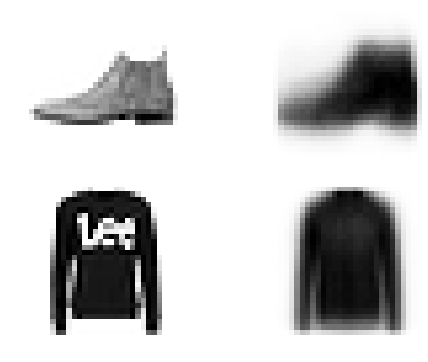

In [48]:
show_reconstructions(hashing_ae)
plt.show()

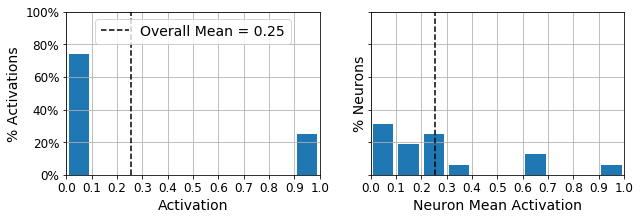

In [49]:
plot_activations_histogram(hashing_encoder)
plt.show()

In [50]:
hashes = np.round(hashing_encoder.predict(X_valid)).astype(np.int32)
hashes *= np.array([[2**bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print("{:016b}".format(h))
print("...")

0000100100000001
0000100100000000
0000100100000001
0000100000000000
0000100000100000
...


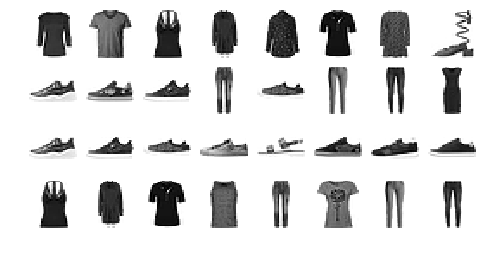

In [51]:
n_bits = 4
n_images = 8
plt.figure(figsize=(n_images, n_bits))
for bit_index in range(n_bits):
    in_bucket = (hashes & 2**bit_index != 0)
    for index, image in zip(range(n_images), X_valid[in_bucket]):
        plt.subplot(n_bits, n_images, bit_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

# Variational Autoencoder

In [52]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return mean + K.exp(log_var / 2) * K.random_normal(shape=tf.shape(log_var))

In [53]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 30

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

kld_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
variational_ae.add_loss(K.mean(kld_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
history = variational_ae.fit(X_train, X_train, epochs=50,
                             validation_data=[X_valid, X_valid],
                             batch_size=128)

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3955 - accuracy: 0.4948 - val_loss: 0.3567 - val_accuracy: 0.4984
Epoch 2/50
55000/55000 [==============================] - 4s 64us/sample - loss: 0.3471 - accuracy: 0.5027 - val_loss: 0.3452 - val_accuracy: 0.4987
Epoch 3/50
55000/55000 [==============================] - 3s 63us/sample - loss: 0.3349 - accuracy: 0.5042 - val_loss: 0.3340 - val_accuracy: 0.5004
Epoch 4/50
55000/55000 [==============================] - 3s 61us/sample - loss: 0.3289 - accuracy: 0.5049 - val_loss: 0.3308 - val_accuracy: 0.5034
Epoch 5/50
55000/55000 [==============================] - 3s 57us/sample - loss: 0.3253 - accuracy: 0.5053 - val_loss: 0.3249 - val_accuracy: 0.5030
Epoch 6/50
55000/55000 [==============================] - 3s 58us/sample - loss: 0.3228 - accuracy: 0.5055 - val_loss: 0.3298 - val_accuracy: 0.5003
Epoch 7/50
55000/55000 [==============================] -

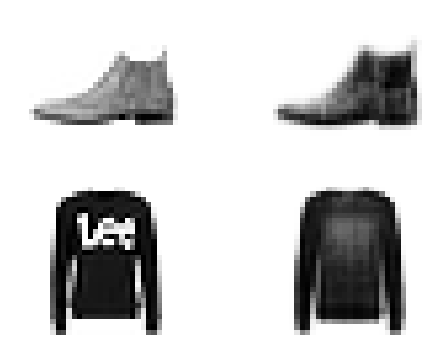

In [54]:
show_reconstructions(variational_ae)
plt.show()

## Generate Fashion Images

Let's train the model and generate a few random fashion images:

In [55]:
tf.random.set_seed(42)
np.random.seed(42)

n_rows = 6
n_cols = 10
codings_rnd = np.random.normal(size=[n_rows * n_cols, codings_size])
images = variational_decoder.predict(codings_rnd)

In [56]:
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

Saving figure generated_fashion_images_plot


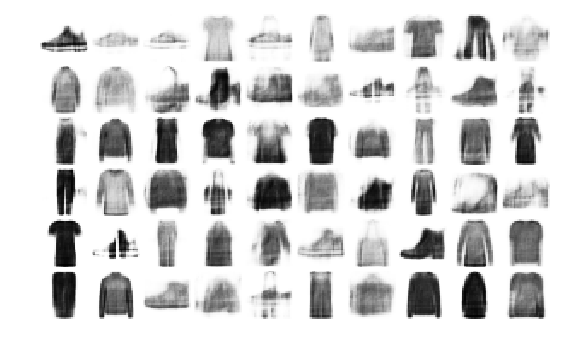

In [57]:
plt.figure(figsize=(8, 5))
plot_multiple_images(images, n_rows, n_cols)
save_fig("generated_fashion_images_plot")

## Encode & Decode

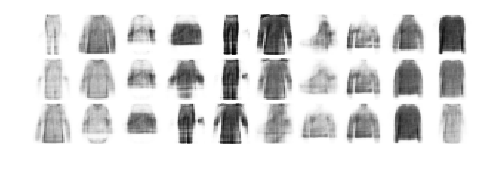

In [58]:
n_iterations = 3
n_images = 10
source_codings = np.random.normal(size=[n_images, codings_size])
target_codings = np.roll(source_codings, -1, axis=0)
images = []
for iteration in range(n_iterations):
    codings_interpolate = source_codings + (target_codings - source_codings) * iteration / n_iterations
    images.append(variational_decoder(codings_interpolate).numpy())
images = np.concatenate(images)

plt.figure(figsize=(8, 3))
plot_multiple_images(images, n_iterations, n_cols)